# Join plots for models

Join in one graph the plots for all p

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model

In [3]:
def model_function(x: float,a1,a2):
    return a1+a2*x

def get_extrapol_function(model_function,a1,a2):
    def extrapol_funct(x):
        return model_function(x,a1,a2)
    return extrapol_funct


## Get data

In [4]:
data_path = Path("../../../data/").resolve()
file_all_tc = 'all_inv_Tc.csv'
df_inv_all_tc = pd.read_csv(os.path.join(data_path,file_all_tc))
file_params = "inv_Tc_vs_inv_nv_sqrt_and_log_2_parms_params_curves.csv"
df_params = pd.read_csv(os.path.join(data_path,"Extrapolation",file_params),index_col=0)
file_extrapol_val = "inv_Tc_vs_inv_nv_sqrt_and_log_2_parms_extrapol_values.csv"
df_extrapol_val = pd.read_csv(os.path.join(data_path,"Extrapolation",file_extrapol_val),index_col=0)

In [5]:
df_params

,P1.0,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
a1,1.000000,0.994000,0.975071,0.953423,0.929431,0.903332,0.875336,0.845526,0.814514,0.782637,0.750422
a2,-0.735426,-0.746685,-0.731702,-0.714068,-0.692617,-0.667744,-0.640485,-0.610011,-0.577592,-0.544030,-0.509231


val 0.15020298933838858


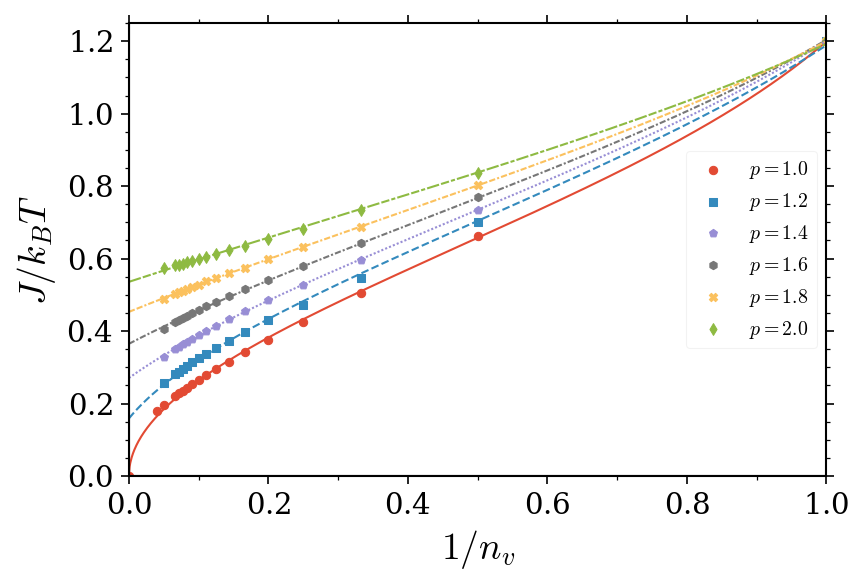

In [7]:
columns = ["P1.0",
#            "P1.1",
           "P1.2",
#            "P1.3",
           "P1.4",
#            "P1.5",
           "P1.6",
#            "P1.7",
           "P1.8",
#            "P1.9",
           "P2.0"]

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False
markers = ["o",
#            "v",
           "s",
#            "P",
           "p",
#            "*",
           "h",
#            "D",
           "X",
#            "8",
           "d"]
line_styles = ["solid",
#                "dotted",
               "dashed",
#                "dashdot",
               (0,(1,1)),
#                (0,(5,1)),
               (0,(3,1,1,1)),
#                (0,(3,1,1,1,1,1)), 
               (0,(3,1,3,1,1,1)),
#                (0,(5,1,3,1,1,1)),
               (0,(6,1,4,1,2,1)),
               (0,(1,10)),
               (0,(5,10)),
               (0,(3,10,1,10))]

fig1: Figure = pyplot.figure(figsize=(6, 4), dpi=150)
grid_spec = GridSpec(1, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

for index,column in enumerate(columns):
    # get p value
    p_val = float(column.replace("P",""))
    # Get inv_tc per col
    y_data_all = df_inv_all_tc.loc[:, column]

    x_data = np.array(df_inv_all_tc.loc[y_data_all.notnull(), "1/nv"])
    y_data = np.array(y_data_all.loc[y_data_all.notnull()])
    
    # add value at nv=1
    x_data = np.concatenate([x_data,[1]])
    y_data = np.concatenate([y_data,[1.19968]])
    
    if column == 'P1.0':
        # add value at nv=infty
        x_data = np.insert(x_data,0,0)
        y_data = np.insert(y_data,0,0)
        
        a1 = 0.8941331066741727
        a2 = 0.8347580777184751
        
        x_data_fine = np.linspace(0, 1, num=1024)
        y_extrapol = a1*np.sqrt(-np.log(1-a2*x_data_fine))
        
        print('val', a1*np.sqrt(-np.log(1-a2*(1/30))))
        
        ax.plot(x_data_fine, y_extrapol, lw=1,linestyle=line_styles[index], color='C'+str(index))
        ax.scatter(x_data, y_data, marker=markers[index], color='C'+str(index),label = '$p=1.0$')

    else:
        # get params
        (a1,a2) = df_params[column].values

        # get model
        extrapol_funct = get_extrapol_function(model_function, a1, a2)    

        # plot
        x_data_fine = np.linspace(0, 1, num=1024)
        y_data_fine = extrapol_funct(x_data_fine)
        ax.plot(x_data_fine, np.sqrt(-np.log(y_data_fine)), lw=1,linestyle=line_styles[index], color='C'+str(index))

        ax.scatter(x_data, y_data, marker=markers[index], color='C'+str(index),label = '$p={}$'.format(p_val))
        
# ticks configuration
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

# labels configurations
ax.xaxis.label.set_size(18)
ax.set_xlabel(r"$1 / n_v$")

ax.yaxis.label.set_size(18)
ax.set_ylabel(r"$J / k_B T$")

ax.set_ylim(0, 1.25)
ax.set_xlim(0, 1)

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.legend(
          loc ="center right",
          fontsize = 9.5
        )
# ax.axvline(x=0,linestyle="-",color="black")
# ax.axhline(y=0,linestyle="-",color="black")

# ax.set_xscale("log")
# ax.set_yscale("log")

pyplot.draw()
pyplot.show()

In [13]:
1/np.arange(1,31
        ,1)

array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
       0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ,
       0.09090909, 0.08333333, 0.07692308, 0.07142857, 0.06666667,
       0.0625    , 0.05882353, 0.05555556, 0.05263158, 0.05      ,
       0.04761905, 0.04545455, 0.04347826, 0.04166667, 0.04      ,
       0.03846154, 0.03703704, 0.03571429, 0.03448276, 0.03333333])

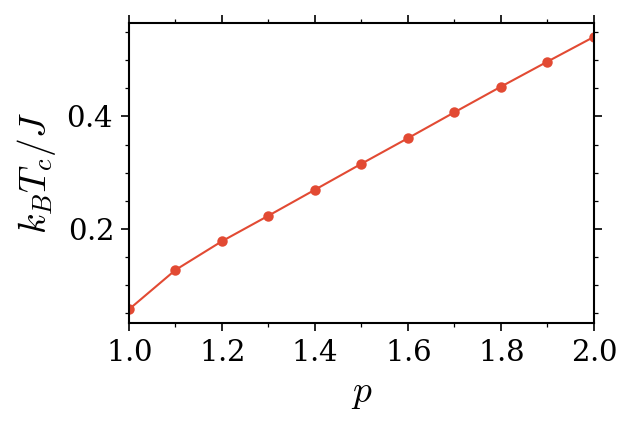

In [12]:
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'inv_Tc_vs_inv_nv_sqrt_and_log_3_parms'
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = np.arange(1,2.1,0.1)
y_data = df_extrapol_val.loc['infty'].values

# x_data = np.delete(x_data,0)
# y_data = np.delete(y_data, 0)
# # data for squared 
# y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=1)

# ticks configuration
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

# labels configurations
ax.xaxis.label.set_size(18)
ax.set_xlabel(r"$p$")

ax.yaxis.label.set_size(18)
ax.set_ylabel(r"$k_BT_c/J$")
# ax.axvline(x=1,linestyle='--')

# ax.set_ylim(1.5,8)
ax.set_xlim(1, 2)


pyplot.draw()

# print('Save graph {}'.format(file_extrapol_graph))
# pyplot.savefig(file_extrapol_graph)

pyplot.show()